In [1]:
# Create plots and tables for the logs of the different runs of the dbs
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import extractor
import ast


# First we look at the different runs that both MariaDB and PostgreSQL have done


| Test Case | `max_connections` | `buffer_pool_size` | `log_buffer_size` | `virtual_users` | `warehouses` | Test Nº |
| --------- | ----------------- | ------------------ | ----------------- | --------------- | ------------ | ------- |
| Small     | 100               | 256M               | 8M                | 5               | 5            | 1       |
| Medium    | 200               | 512M               | 16M               | 10              | 10           | 2       |
| Large     | 500               | 1G                 | 32M               | 20              | 20           | 3       |
| Max CPU   | 500               | 2G                 | 64M               | 50              | 20           | 4       |
| I/O Test  | 200               | 256M               | 8M                | 20              | 5            | 5       |
| Memory    | 200               | 2G                 | 64M               | 10              | 10           | 6       |
| Latency   | 100               | 128M               | 8M                | 5               | 20           | 7       |
| Stress    | 1000              | 4G                 | 128M              | 100             | 50           | 8       |

For each of these scenatios we also ran with the use all warehouses option to both false and true. So that we could see the impact of using all warehouses on the performance of the database.

Aditionally both group members ran all the same scenarios with the same parameters.

Their machine specifications were:
| Machine | CPU | RAM | Disk Type | OS Version | 
| ------- | --- | --- | --------- | ---------- |
| José Pedreira | Apple M4 Pro, 12 cores (8 performance cores + 4 efficiency cores) | 24 GB DDR4 | SSD       | macOS 15.5 (24F74) with Ubuntu 20.04 LTS running on a VM  |
| Diogo Matos |  |  |  |


# Let's look at the results of the runs for MariaDB first with the warehouses set to false

In [2]:
extractor.extract_all_logs_to_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/")

✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu100_wh50_mc1000_bp4G_lb128_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu10_wh10_mc200_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu10_wh10_mc200_bp512M_lb16_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu20_wh20_mc500_bp1G_lb32_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu20_wh5_mc200_bp256M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu50_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu5_wh20_mc100_bp128M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/tpcc_vu5_wh5_mc100_bp256M_lb8_dict.txt
Extracted 32 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run1.log (Test 8: Stress)
Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run2.log (Test 8: Stress)
Extracted 32 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run3.log (Test 8: Stress

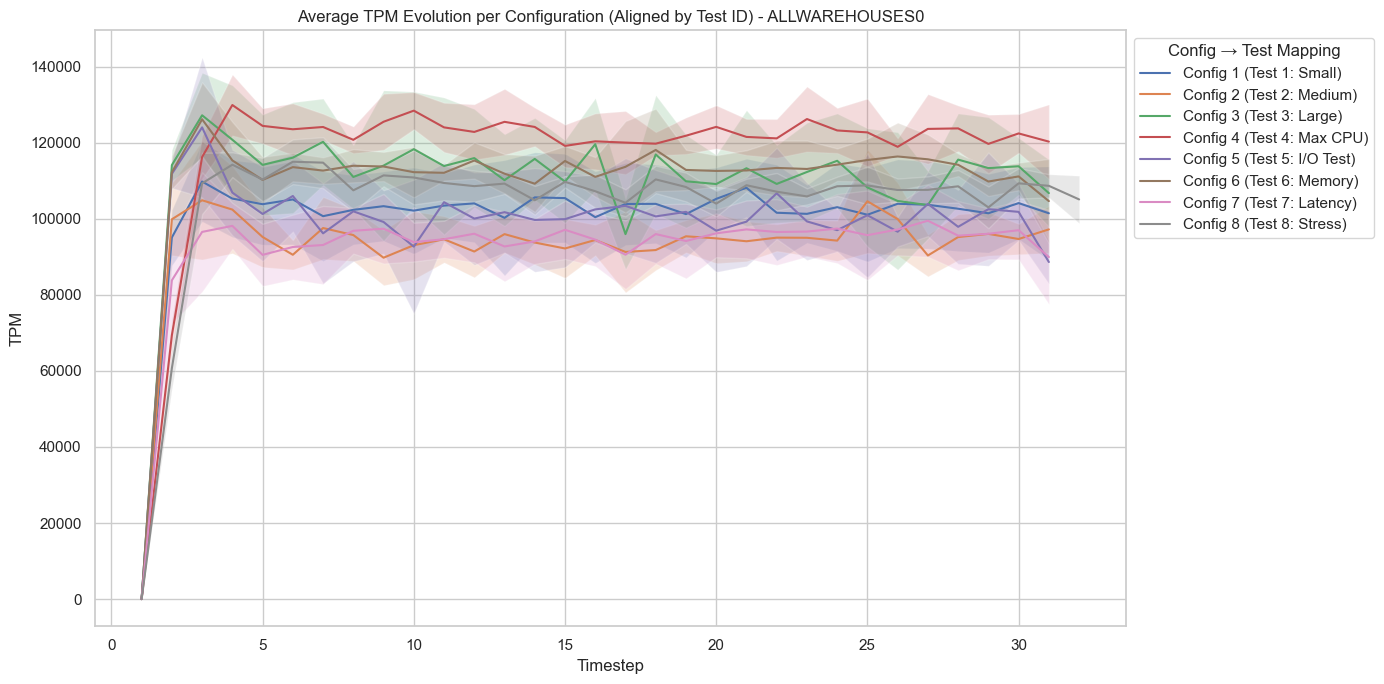

In [3]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES0")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

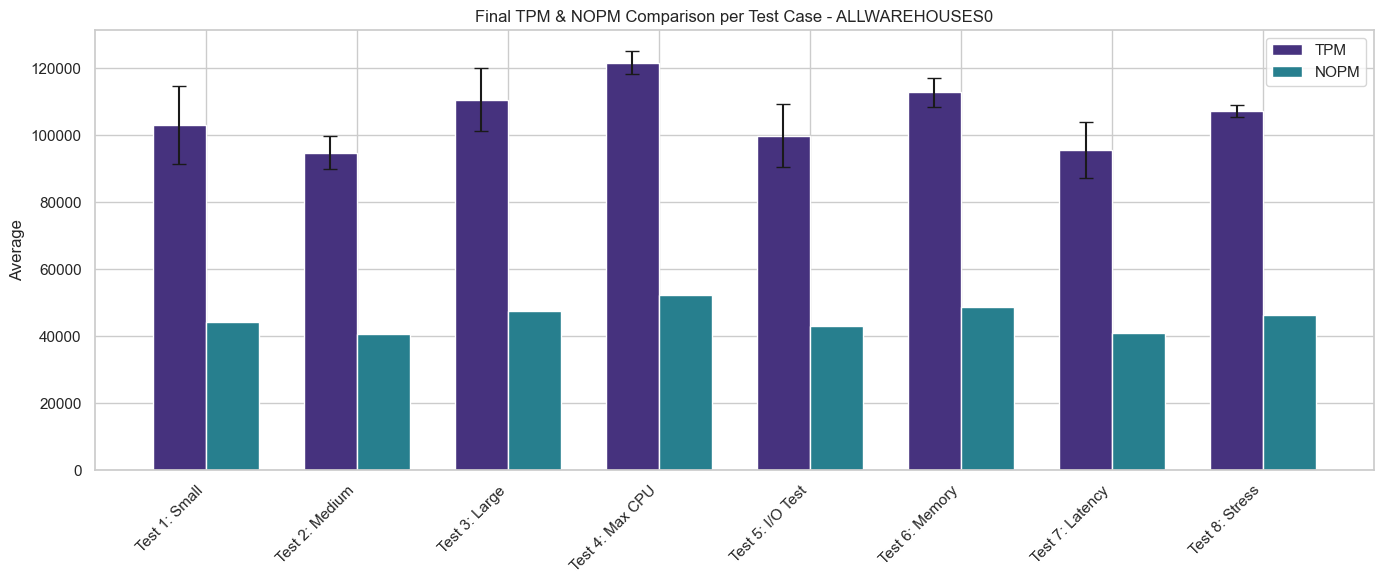

In [4]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES0")
plt.legend()
plt.tight_layout()
plt.show()

# Now with the warehouses set to true

In [5]:
extractor.extract_all_logs_to_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/")

✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu100_wh50_mc1000_bp4G_lb128_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu10_wh10_mc200_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu10_wh10_mc200_bp512M_lb16_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu20_wh20_mc500_bp1G_lb32_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu20_wh5_mc200_bp256M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu50_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu5_wh20_mc100_bp128M_lb8_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/tpcc_vu5_wh5_mc100_bp256M_lb8_dict.txt
Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run1.log (Test 8: Stress)
Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run2.log (Test 8: Stress)
Extracted 33 TPM from tpcc_vu100_wh50_mc1000_bp4G_lb128_run3.log (Test 8: Stress

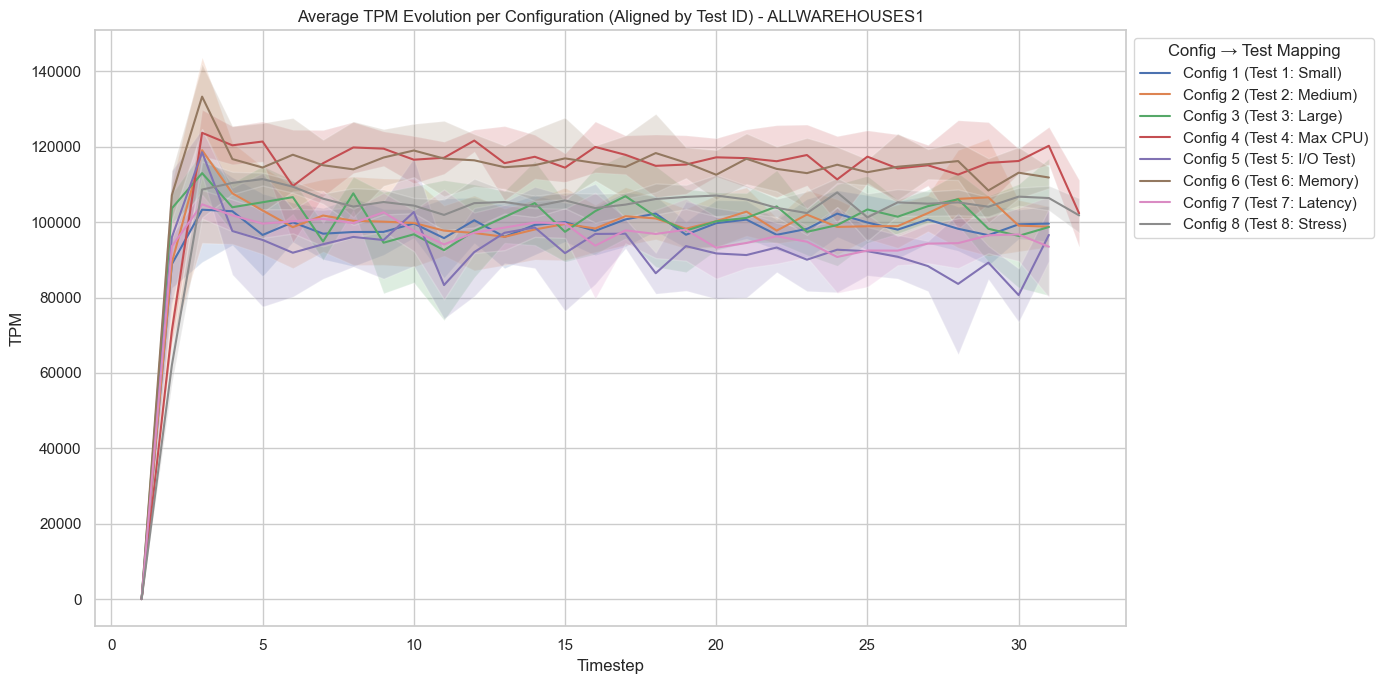

In [6]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES1")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

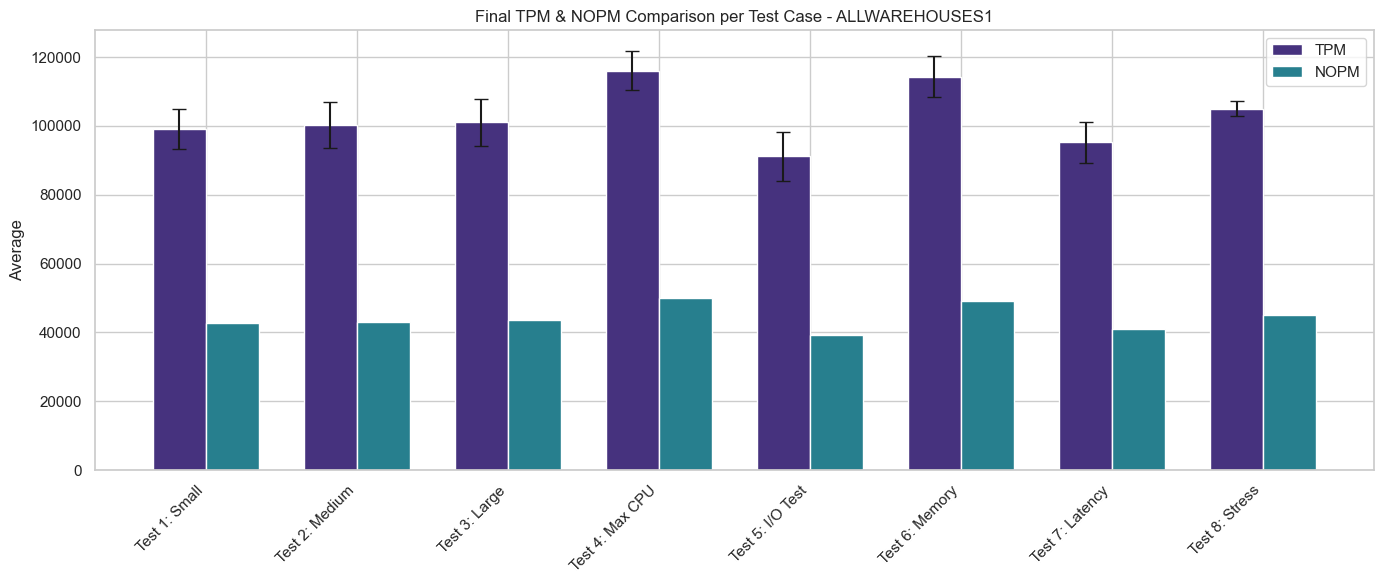

In [7]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES1")
plt.legend()
plt.tight_layout()
plt.show()

# Let's to see if the warehouses setting has an impact on the performance of the database.

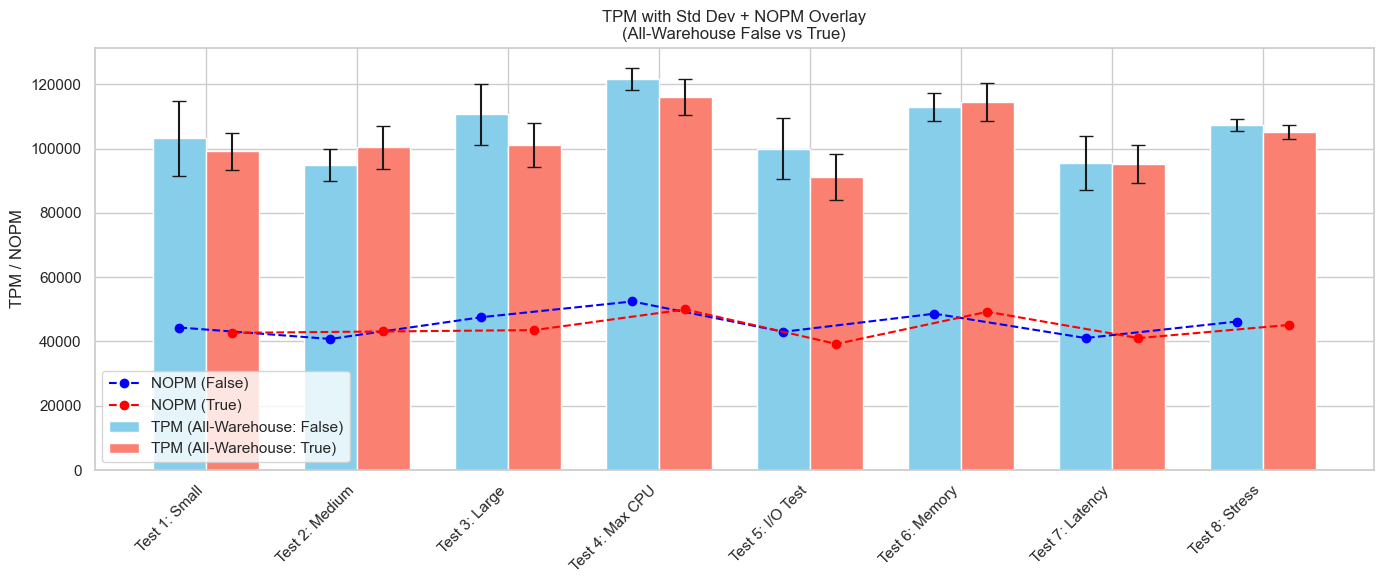

In [8]:
df0 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv")
df1 = pd.read_csv("hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv")

df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

grouped = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    avg_nopm=('final_nopm', 'mean')
).reset_index()

grouped = grouped.sort_values('test_id')

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

x_labels = [f"Test {tid}: {name}" for tid, name in grouped.groupby('test_id').first()['test_name'].items()]
x = np.arange(len(x_labels))
bar_width = 0.35

bar_false = grouped[grouped['allwarehouse'] == False]
bar_true = grouped[grouped['allwarehouse'] == True]

bars1 = plt.bar(x - bar_width/2, bar_false['avg_tpm'], yerr=bar_false['std_tpm'], capsize=5,
                width=bar_width, label='TPM (All-Warehouse: False)', color='skyblue')
bars2 = plt.bar(x + bar_width/2, bar_true['avg_tpm'], yerr=bar_true['std_tpm'], capsize=5,
                width=bar_width, label='TPM (All-Warehouse: True)', color='salmon')

plt.plot(x - bar_width/2, bar_false['avg_nopm'], marker='o', linestyle='--', color='blue', label='NOPM (False)')
plt.plot(x + bar_width/2, bar_true['avg_nopm'], marker='o', linestyle='--', color='red', label='NOPM (True)')

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("TPM / NOPM")
plt.title("TPM with Std Dev + NOPM Overlay\n(All-Warehouse False vs True)")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

agg_df = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    min_tpm=('final_tpm', 'min'),
    max_tpm=('final_tpm', 'max'),
    avg_nopm=('final_nopm', 'mean'),
    std_nopm=('final_nopm', 'std'),
    min_nopm=('final_nopm', 'min'),
    max_nopm=('final_nopm', 'max'),
    runs=('filename', 'count')
).reset_index()

from IPython.display import display
display(agg_df)
agg_df.to_csv("aggregated_results.csv", index=False)
print("Exported as aggregated_results.csv")

,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
0,1,Small,False,103168.6,11692.339984,91181,120187,44345.6,4938.537415,39260,51525,5
1,1,Small,True,99166.8,5820.684084,89037,103089,42688.6,2524.298576,38287,44320,5
2,2,Medium,False,94839.8,4996.440853,89365,101887,40787.8,2176.199830,38435,43851,5
3,2,Medium,True,100341.4,6638.772424,94660,109554,43116.8,2877.303981,40545,47108,5
4,3,Large,False,110600.4,9358.924447,99266,124666,47555.4,4001.246656,42694,53554,5
5,3,Large,True,101104.8,6849.694022,90643,108927,43539.4,2961.477131,38959,46829,5
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
7,4,Max CPU,True,115993.6,5678.209427,106196,120932,49971.0,2428.002986,45737,51913,5
8,5,I/O Test,False,99867.8,9480.759474,89498,114030,43017.8,4139.339645,38482,49215,5
9,5,I/O Test,True,91206.2,7081.485098,83041,101281,39237.6,3090.050210,35615,43516,5


Exported as aggregated_results.csv


In [10]:
# Best configuration by average TPM
best_tpm_row = agg_df.loc[agg_df['avg_tpm'].idxmax()]
print("Best TPM configuration:")
display(best_tpm_row)

# Top 3 configurations
top3 = agg_df.sort_values('avg_tpm', ascending=False).head(3)
print("Top 3 Configurations by Avg TPM:")
display(top3)

Best TPM configuration:


test_id                   4
test_name           Max CPU
allwarehouse          False
avg_tpm            121708.2
std_tpm         3361.480953
min_tpm              117845
max_tpm              125544
avg_nopm            52446.6
std_nopm        1458.146872
min_nopm              50713
max_nopm              54138
runs                      5
Name: 6, dtype: object

Top 3 Configurations by Avg TPM:


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
7,4,Max CPU,True,115993.6,5678.209427,106196,120932,49971.0,2428.002986,45737,51913,5
11,6,Memory,True,114346.8,5893.961715,107234,120905,49247.4,2486.111683,46270,51993,5


Correlation between avg TPM and avg NOPM: 1.00


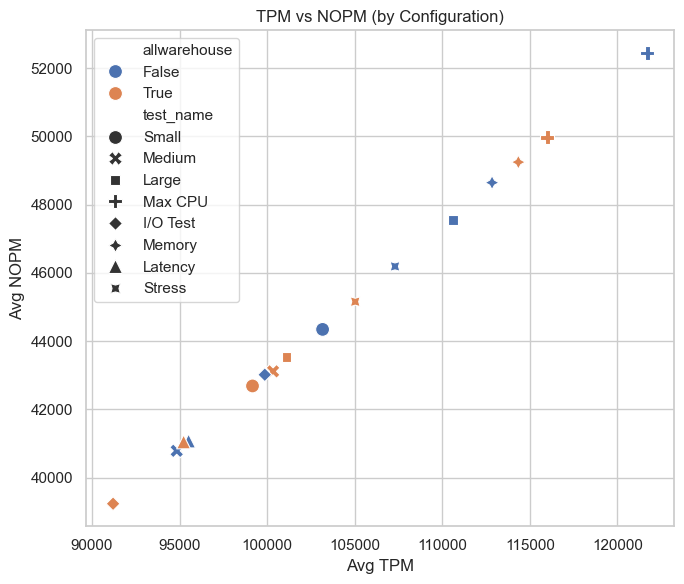

In [11]:
# Correlation coefficient
corr = agg_df[['avg_tpm', 'avg_nopm']].corr().iloc[0, 1]
print(f"Correlation between avg TPM and avg NOPM: {corr:.2f}")

# Scatter plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=agg_df, x='avg_tpm', y='avg_nopm', hue='allwarehouse', style='test_name', s=100)
plt.title("TPM vs NOPM (by Configuration)")
plt.xlabel("Avg TPM")
plt.ylabel("Avg NOPM")
plt.grid(True)
plt.tight_layout()
plt.show()

Most Stable (Lowest std_tpm):


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
14,8,Stress,False,107304.0,1806.682595,105169,109246,46191.2,742.139273,45246,46919,5
15,8,Stress,True,105031.8,2205.134168,101953,107792,45157.2,998.073494,43672,46301,5
6,4,Max CPU,False,121708.2,3361.480953,117845,125544,52446.6,1458.146872,50713,54138,5
10,6,Memory,False,112844.8,4288.987783,106163,118100,48646.0,1773.267464,45863,50771,5
2,2,Medium,False,94839.8,4996.440853,89365,101887,40787.8,2176.199830,38435,43851,5


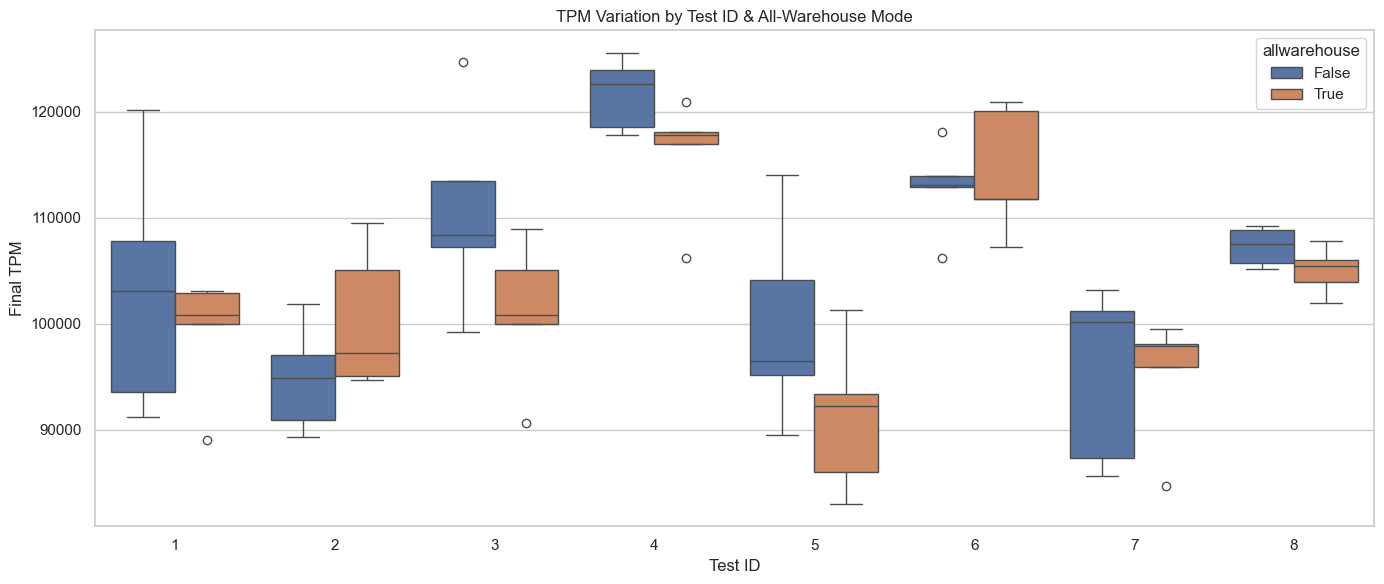

In [12]:
# Top 5 most stable configurations (lowest std)
most_stable = agg_df.sort_values('std_tpm').head(5)
print("Most Stable (Lowest std_tpm):")
display(most_stable)

# Boxplot of TPM variation
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='test_id', y='final_tpm', hue='allwarehouse')
plt.title("TPM Variation by Test ID & All-Warehouse Mode")
plt.xlabel("Test ID")
plt.ylabel("Final TPM")
plt.tight_layout()
plt.show()

# Let's have a look at the PostgreSQL 

In [13]:
extractor.extract_all_logs_to_csv("hammer_scripts/Postgres_logs_ALLWAREHOUSES0/")

✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu100_wh50_mc1000_sb4GB_wb128_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu10_wh10_mc200_sb2GB_wb64_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu10_wh10_mc200_sb512MB_wb16_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu20_wh20_mc500_sb1GB_wb32_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu20_wh5_mc200_sb256MB_wb8_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu50_wh20_mc500_sb2GB_wb64_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu5_wh20_mc100_sb128MB_wb8_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES0/pg_vu5_wh5_mc100_sb256MB_wb8_dict.txt
Extracted 31 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run1.log (Test 8: Stress)
Extracted 32 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run2.log (Test 8: Stress)
Extracted 32 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run3.log (Test 8: Stress)
E

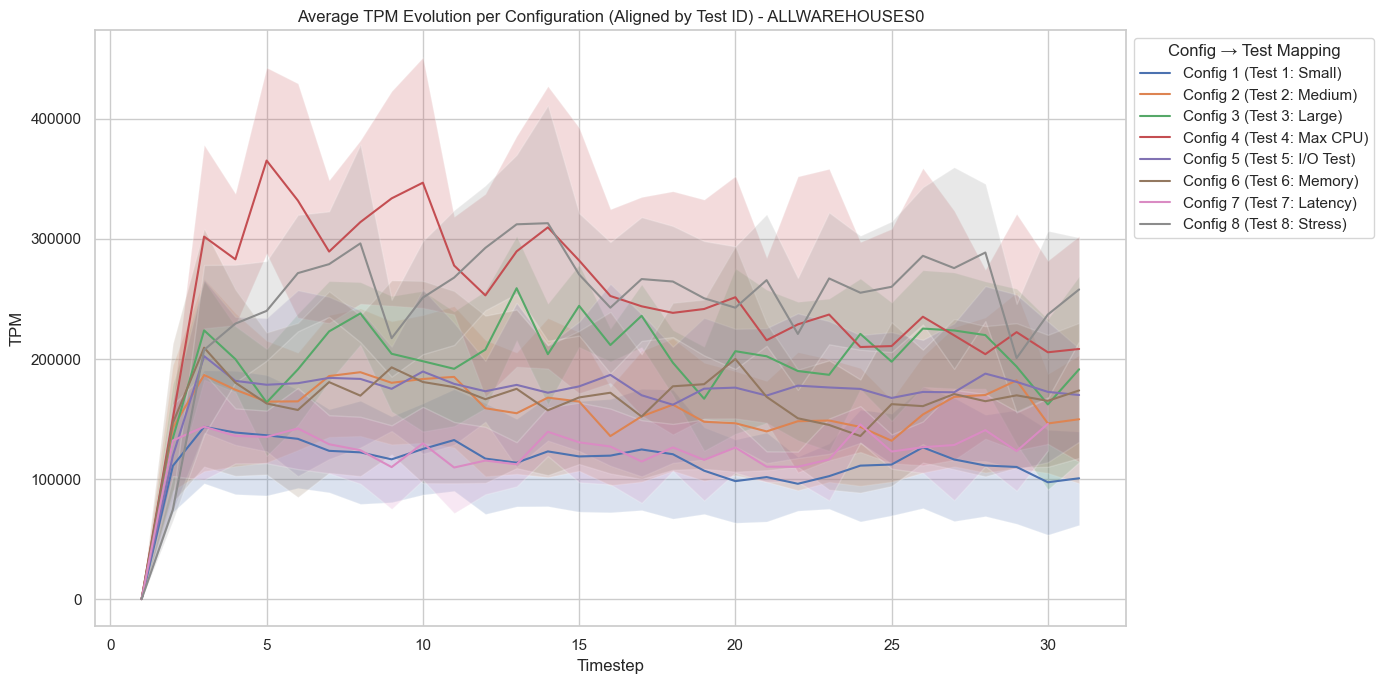

In [14]:
df = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES0")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

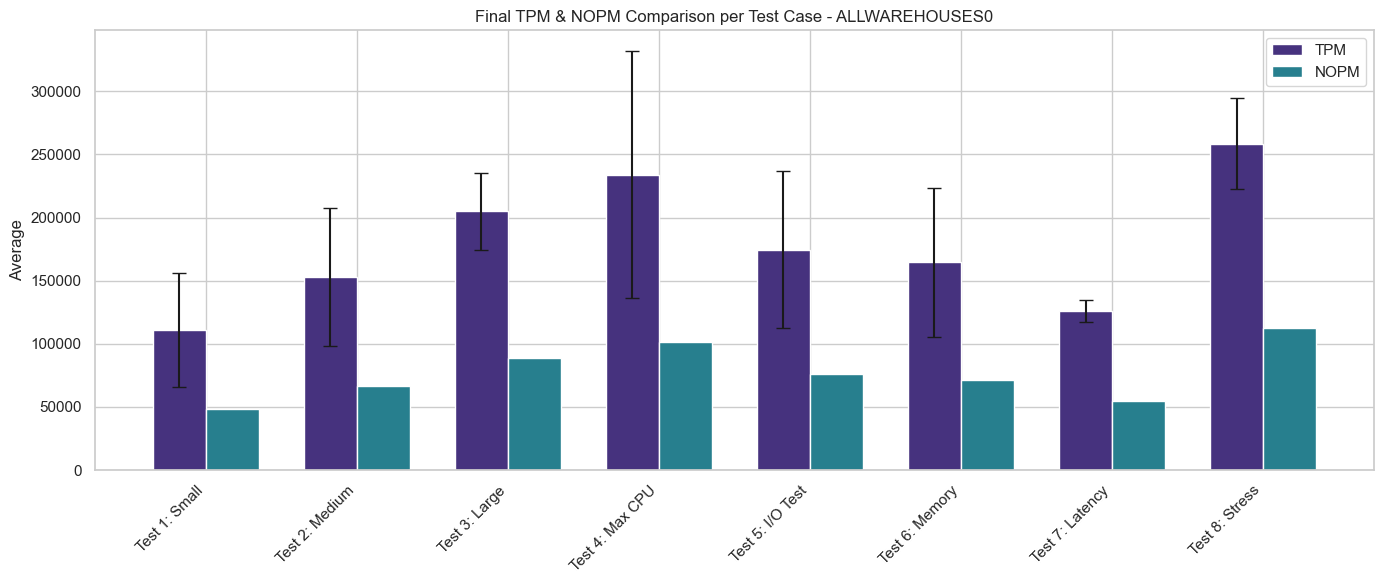

In [15]:
df = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES0/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES0")
plt.legend()
plt.tight_layout()
plt.show()

# Now with the warehouses set to true

In [16]:
extractor.extract_all_logs_to_csv("hammer_scripts/Postgres_logs_ALLWAREHOUSES1/")

✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu100_wh50_mc1000_sb4GB_wb128_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu10_wh10_mc200_sb2GB_wb64_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu10_wh10_mc200_sb512MB_wb16_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu20_wh20_mc500_sb1GB_wb32_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu20_wh5_mc200_sb256MB_wb8_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu50_wh20_mc500_sb2GB_wb64_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu5_wh20_mc100_sb128MB_wb8_dict.txt
✅ Cleaned: hammer_scripts/Postgres_logs_ALLWAREHOUSES1/pg_vu5_wh5_mc100_sb256MB_wb8_dict.txt
Extracted 31 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run1.log (Test 8: Stress)
Extracted 32 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run2.log (Test 8: Stress)
Extracted 32 TPM from pg_vu100_wh50_mc1000_sb4GB_wb128_run3.log (Test 8: Stress)
E

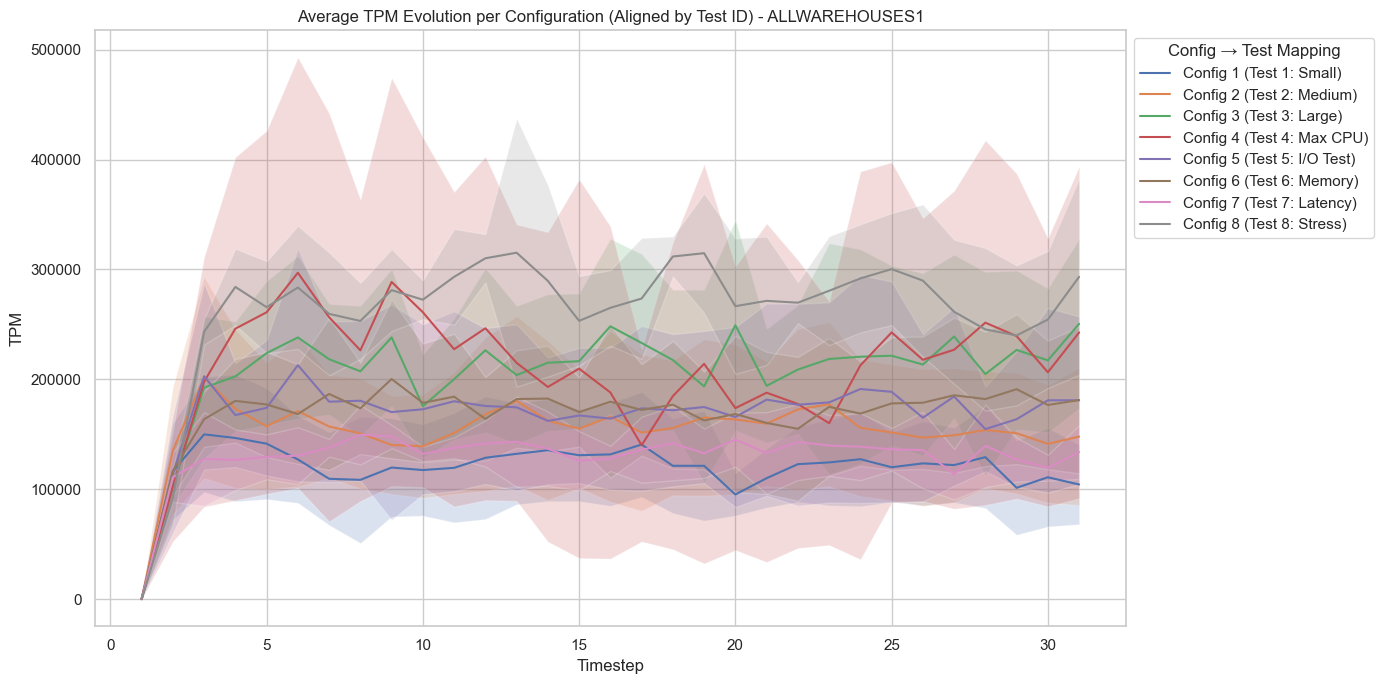

In [17]:
df = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES1")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

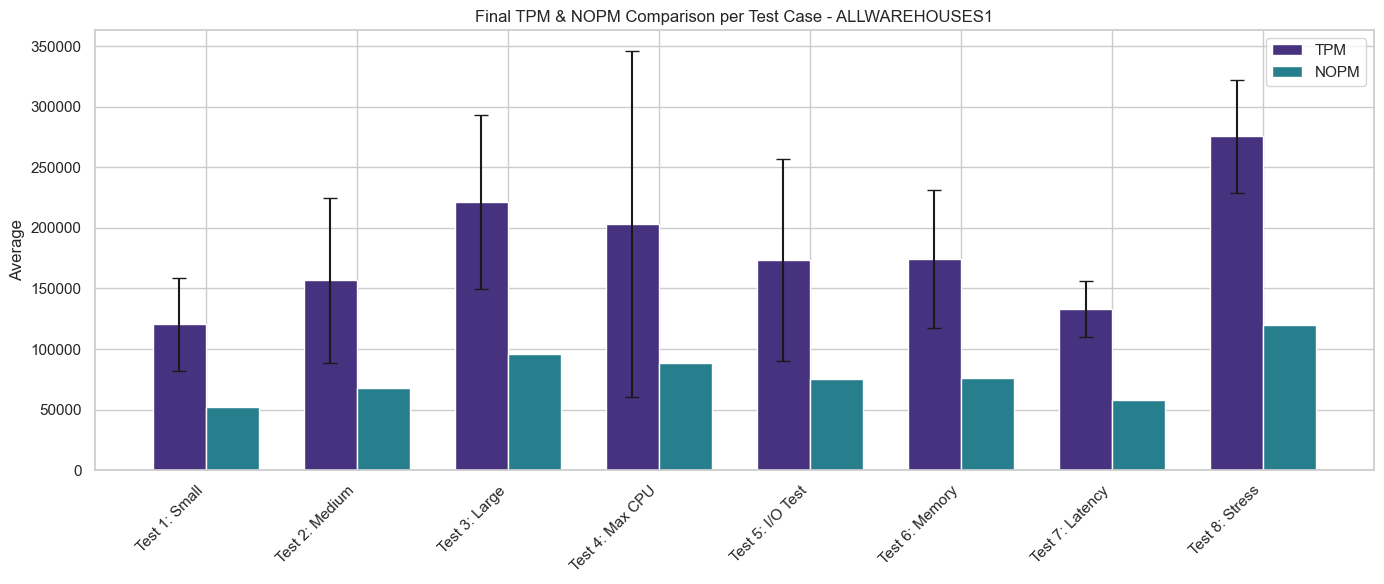

In [18]:
df = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES1/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES1")
plt.legend()
plt.tight_layout()
plt.show()

# Let's to see if the warehouses setting has an impact on the performance of the database.

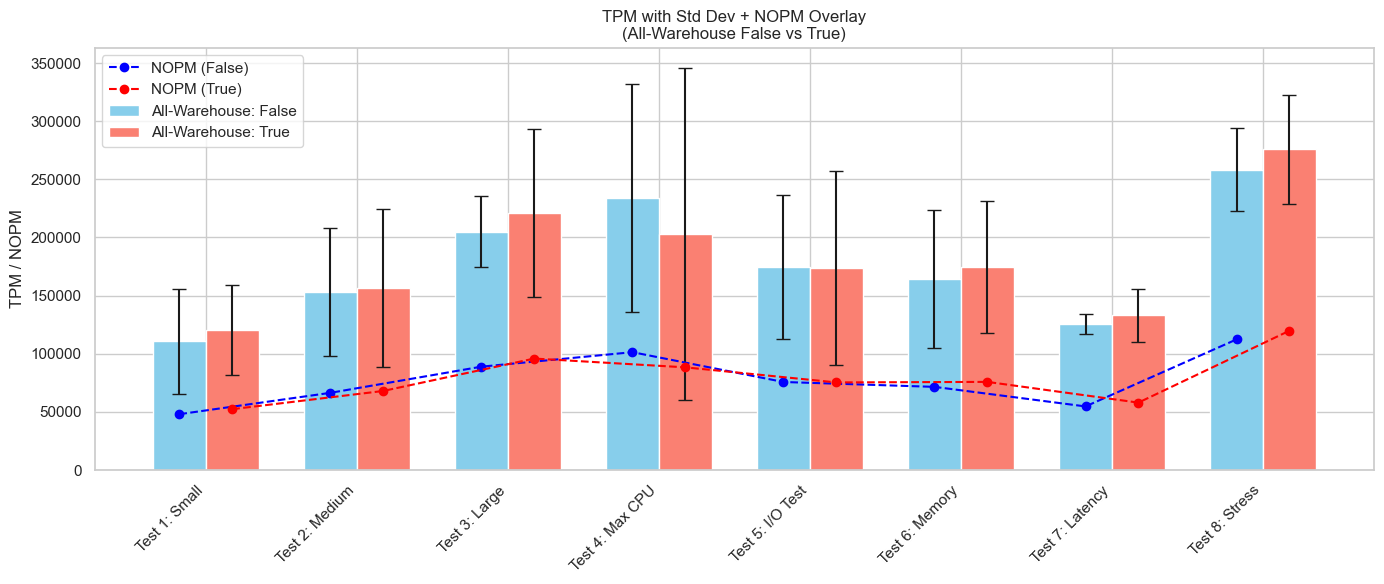

In [19]:
df0 = pd.read_csv("hammer_scripts/Postgres_logs_ALLWAREHOUSES0/summary.csv")
df1 = pd.read_csv("hammer_scripts/Postgres_logs_ALLWAREHOUSES1/summary.csv")

df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

grouped = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    avg_nopm=('final_nopm', 'mean'),
    std_nopm=('final_nopm', 'std')
).reset_index()

grouped = grouped.sort_values('test_id')

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

x_labels = [f"Test {tid}: {name}" for tid, name in grouped.groupby('test_id').first()['test_name'].items()]
x = np.arange(len(x_labels))
bar_width = 0.35

bar_false = grouped[grouped['allwarehouse'] == False]
bar_true = grouped[grouped['allwarehouse'] == True]

bars1 = plt.bar(x - bar_width/2, bar_false['avg_tpm'], yerr=bar_false['std_tpm'], capsize=5,
                width=bar_width, label='All-Warehouse: False', color='skyblue')
bars2 = plt.bar(x + bar_width/2, bar_true['avg_tpm'], yerr=bar_true['std_tpm'], capsize=5,
                width=bar_width, label='All-Warehouse: True', color='salmon')

plt.plot(x - bar_width/2, bar_false['avg_nopm'], marker='o', linestyle='--', color='blue', label='NOPM (False)')
plt.plot(x + bar_width/2, bar_true['avg_nopm'], marker='o', linestyle='--', color='red', label='NOPM (True)')

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("TPM / NOPM")
plt.title("TPM with Std Dev + NOPM Overlay\n(All-Warehouse False vs True)")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
df0['allwarehouse'] = False
df1['allwarehouse'] = True

df = pd.concat([df0, df1], ignore_index=True)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)
df['allwarehouse'] = df['allwarehouse'].astype(bool)

agg_df = df.groupby(['test_id', 'test_name', 'allwarehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std'),
    min_tpm=('final_tpm', 'min'),
    max_tpm=('final_tpm', 'max'),
    avg_nopm=('final_nopm', 'mean'),
    std_nopm=('final_nopm', 'std'),
    min_nopm=('final_nopm', 'min'),
    max_nopm=('final_nopm', 'max'),
    runs=('filename', 'count')
).reset_index()

from IPython.display import display
display(agg_df)
agg_df.to_csv("aggregated_results.csv", index=False)
print("Exported as aggregated_results.csv")

,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
0,1,Small,False,110931.6,45196.728696,75945,166824,48084.2,19586.683173,32828,72398,5
1,1,Small,True,120450.2,38351.739794,80089,164446,52390.4,16693.090990,34782,71615,5
2,2,Medium,False,153022.6,54751.353598,81822,203466,66445.2,23807.884602,35583,88483,5
3,2,Medium,True,156613.4,68132.115796,77341,220155,68055.0,29464.223450,33694,95031,5
4,3,Large,False,205094.6,30461.277202,163263,230268,88943.0,13049.332876,71090,99528,5
5,3,Large,True,221098.6,71836.314120,101201,290429,95918.8,31202.012999,43852,125906,5
6,4,Max CPU,False,233892.6,97729.764309,145716,346923,101399.2,42428.422345,63098,150061,5
7,4,Max CPU,True,203001.4,142778.179071,59747,348441,88361.4,62108.180977,25928,151645,5
8,5,I/O Test,False,174559.8,61957.130136,131157,281782,75771.2,26926.432120,57030,122365,5
9,5,I/O Test,True,173421.0,83335.172682,110533,285843,75398.4,36137.617372,48151,123992,5


Exported as aggregated_results.csv


In [21]:
# Best configuration by average TPM
best_tpm_row = agg_df.loc[agg_df['avg_tpm'].idxmax()]
print("Best TPM configuration:")
display(best_tpm_row)

# Top 3 configurations
top3 = agg_df.sort_values('avg_tpm', ascending=False).head(3)
print("Top 3 Configurations by Avg TPM:")
display(top3)

Best TPM configuration:


test_id                    8
test_name             Stress
allwarehouse            True
avg_tpm             275695.8
std_tpm          46739.17715
min_tpm               204093
max_tpm               327289
avg_nopm            119838.8
std_nopm        20159.394354
min_nopm               88900
max_nopm              141984
runs                       5
Name: 15, dtype: object

Top 3 Configurations by Avg TPM:


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
15,8,Stress,True,275695.8,46739.177150,204093,327289,119838.8,20159.394354,88900,141984,5
14,8,Stress,False,258442.8,35898.693022,223866,307045,112386.6,15476.720657,97398,133278,5
6,4,Max CPU,False,233892.6,97729.764309,145716,346923,101399.2,42428.422345,63098,150061,5


Correlation between avg TPM and avg NOPM: 1.00


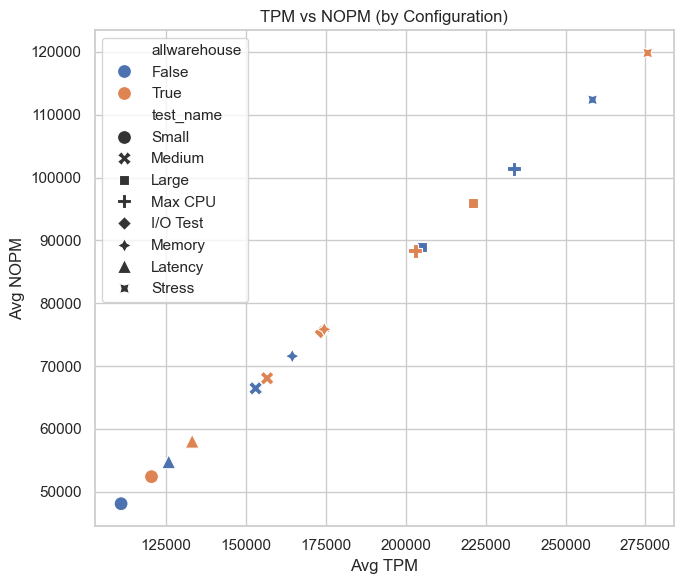

In [22]:
# Correlation coefficient
corr = agg_df[['avg_tpm', 'avg_nopm']].corr().iloc[0, 1]
print(f"Correlation between avg TPM and avg NOPM: {corr:.2f}")

# Scatter plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=agg_df, x='avg_tpm', y='avg_nopm', hue='allwarehouse', style='test_name', s=100)
plt.title("TPM vs NOPM (by Configuration)")
plt.xlabel("Avg TPM")
plt.ylabel("Avg NOPM")
plt.grid(True)
plt.tight_layout()
plt.show()

Most Stable (Lowest std_tpm):


,test_id,test_name,allwarehouse,avg_tpm,std_tpm,min_tpm,max_tpm,avg_nopm,std_nopm,min_nopm,max_nopm,runs
12,7,Latency,False,125834.4,8699.451437,117316,137504,54757.8,3806.196816,50800,59680,5
13,7,Latency,True,133179.4,22953.226926,93975,149255,58026.8,10071.827699,40892,65121,5
4,3,Large,False,205094.6,30461.277202,163263,230268,88943.0,13049.332876,71090,99528,5
14,8,Stress,False,258442.8,35898.693022,223866,307045,112386.6,15476.720657,97398,133278,5
1,1,Small,True,120450.2,38351.739794,80089,164446,52390.4,16693.090990,34782,71615,5


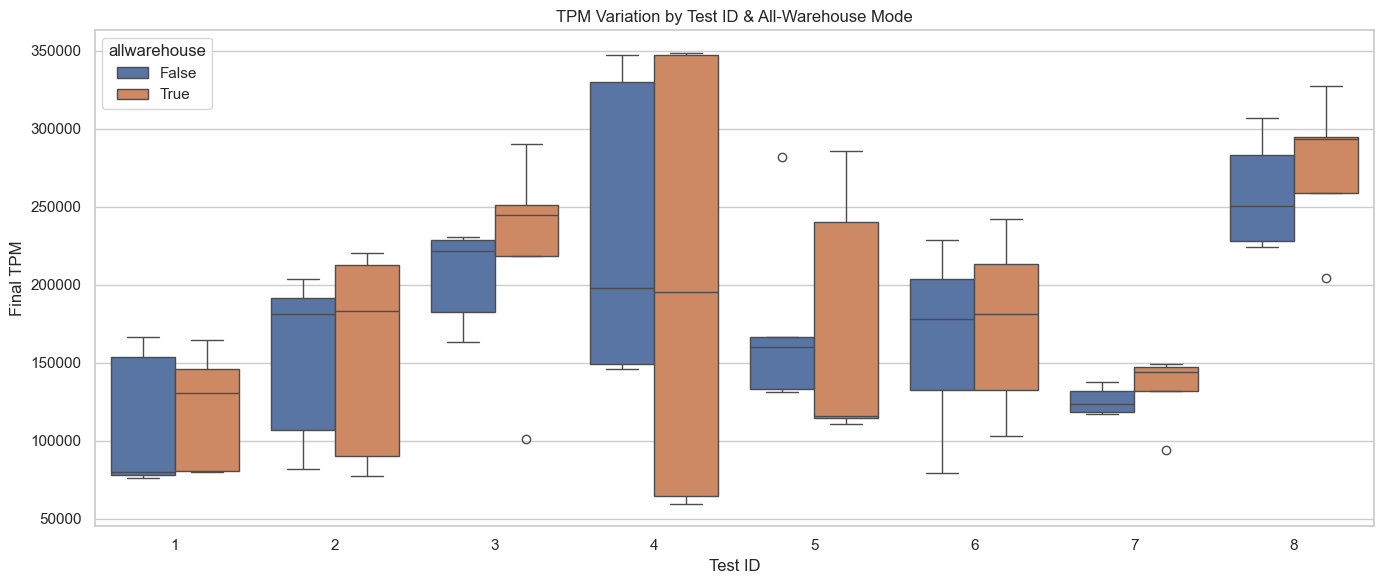

In [23]:
# Top 5 most stable configurations (lowest std)
most_stable = agg_df.sort_values('std_tpm').head(5)
print("Most Stable (Lowest std_tpm):")
display(most_stable)

# Boxplot of TPM variation
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='test_id', y='final_tpm', hue='allwarehouse')
plt.title("TPM Variation by Test ID & All-Warehouse Mode")
plt.xlabel("Test ID")
plt.ylabel("Final TPM")
plt.tight_layout()
plt.show()

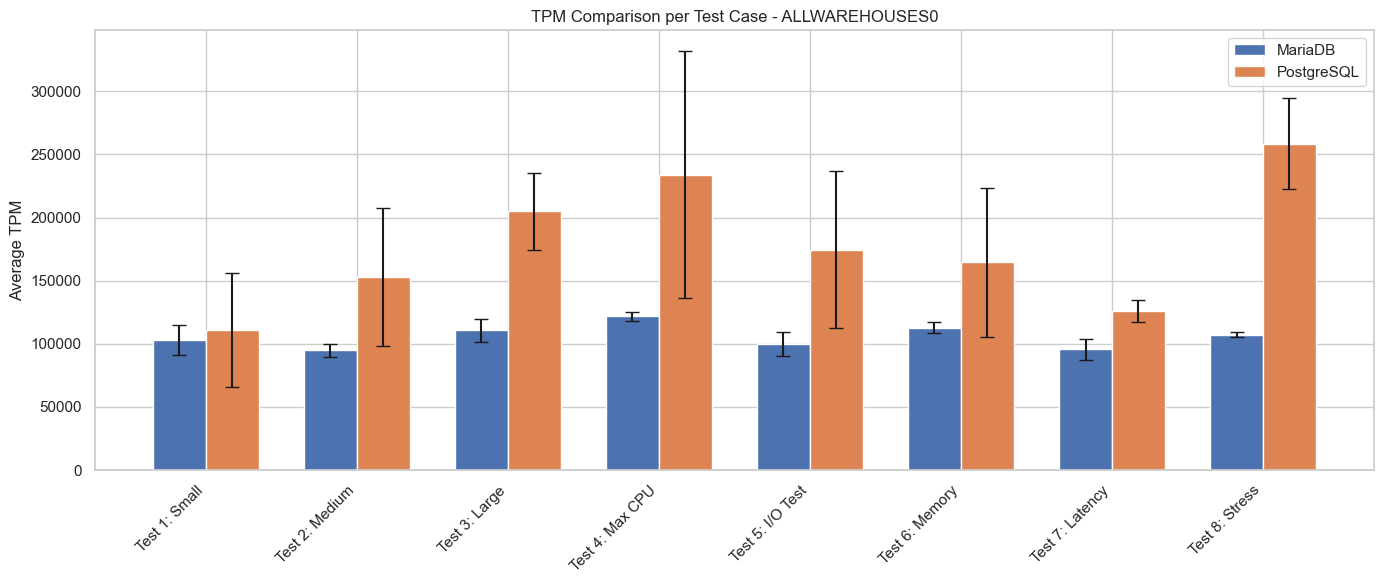

In [24]:
df_mariadb = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df_mariadb['db'] = 'MariaDB'
df_mariadb['config_id'] = df_mariadb['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df_mariadb['tpm_values'] = df_mariadb['tpm_values'].apply(ast.literal_eval)
df_mariadb = df_mariadb[df_mariadb['test_id'].notna()]
df_mariadb['test_id'] = df_mariadb['test_id'].astype(int)
df_mariadb['test_name'] = df_mariadb['test_name'].astype(str)

df_postgres = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES0/summary.csv')
df_postgres['db'] = 'PostgreSQL'
df_postgres['config_id'] = df_postgres['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df_postgres['tpm_values'] = df_postgres['tpm_values'].apply(ast.literal_eval)
df_postgres = df_postgres[df_postgres['test_id'].notna()]
df_postgres['test_id'] = df_postgres['test_id'].astype(int)
df_postgres['test_name'] = df_postgres['test_name'].astype(str)

df_combined = pd.concat([df_mariadb, df_postgres], ignore_index=True)

summary_stats = df_combined.groupby(['test_id', 'test_name', 'db']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std')
).reset_index()

summary_stats = summary_stats.sort_values(by=['test_id', 'db'])

sns.set(style="whitegrid")
unique_tests = summary_stats[['test_id', 'test_name']].drop_duplicates()
x_labels = [f"Test {tid}: {name}" for tid, name in zip(unique_tests['test_id'], unique_tests['test_name'])]
x = np.arange(len(unique_tests))  # positions for each test case
width = 0.35

mariadb_stats = summary_stats[summary_stats['db'] == 'MariaDB']
postgres_stats = summary_stats[summary_stats['db'] == 'PostgreSQL']

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    mariadb_stats['avg_final_tpm'],
    width=width,
    label='MariaDB',
    yerr=mariadb_stats['std_final_tpm'],
    capsize=5
)

plt.bar(
    x + width/2,
    postgres_stats['avg_final_tpm'],
    width=width,
    label='PostgreSQL',
    yerr=postgres_stats['std_final_tpm'],
    capsize=5
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average TPM")
plt.title("TPM Comparison per Test Case - ALLWAREHOUSES0")
plt.legend()
plt.tight_layout()
plt.show()


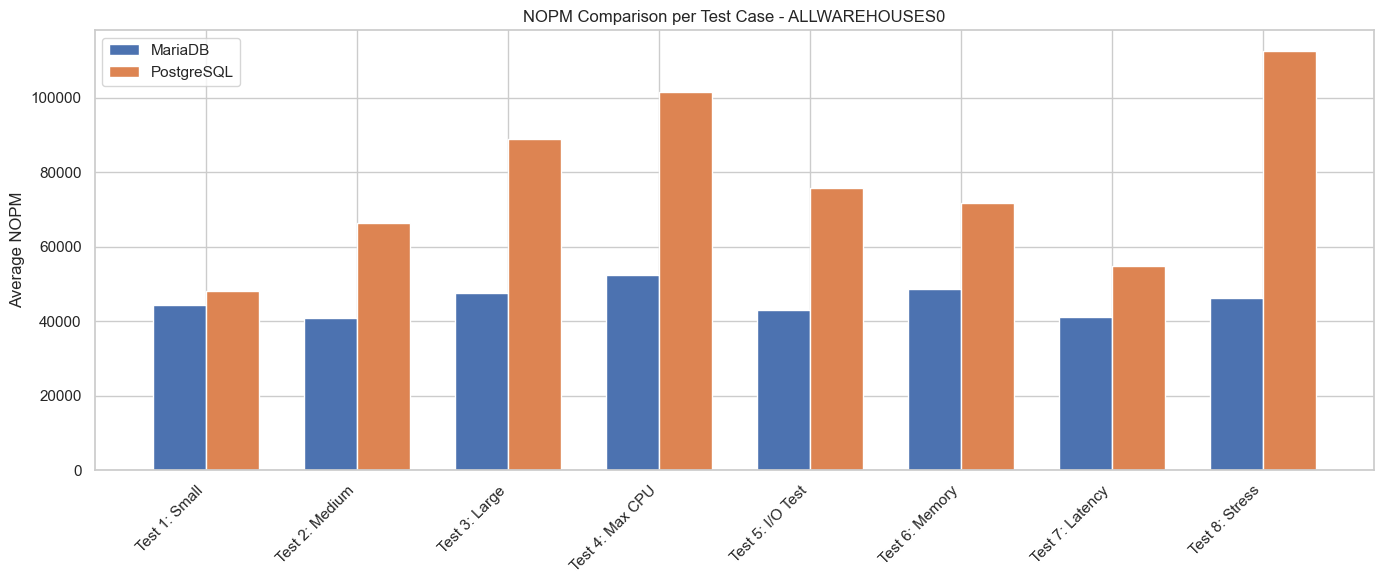

In [25]:
summary_stats = df_combined.groupby(['test_id', 'test_name', 'db']).agg(
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values(by=['test_id', 'db'])

sns.set(style="whitegrid")
unique_tests = summary_stats[['test_id', 'test_name']].drop_duplicates()
x_labels = [f"Test {tid}: {name}" for tid, name in zip(unique_tests['test_id'], unique_tests['test_name'])]
x = np.arange(len(unique_tests)) 
width = 0.35

mariadb_stats = summary_stats[summary_stats['db'] == 'MariaDB']
postgres_stats = summary_stats[summary_stats['db'] == 'PostgreSQL']

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    mariadb_stats['avg_final_nopm'],
    width=width,
    label='MariaDB'
)

plt.bar(
    x + width/2,
    postgres_stats['avg_final_nopm'],
    width=width,
    label='PostgreSQL'
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average NOPM")
plt.title("NOPM Comparison per Test Case - ALLWAREHOUSES0")
plt.legend()
plt.tight_layout()
plt.show()


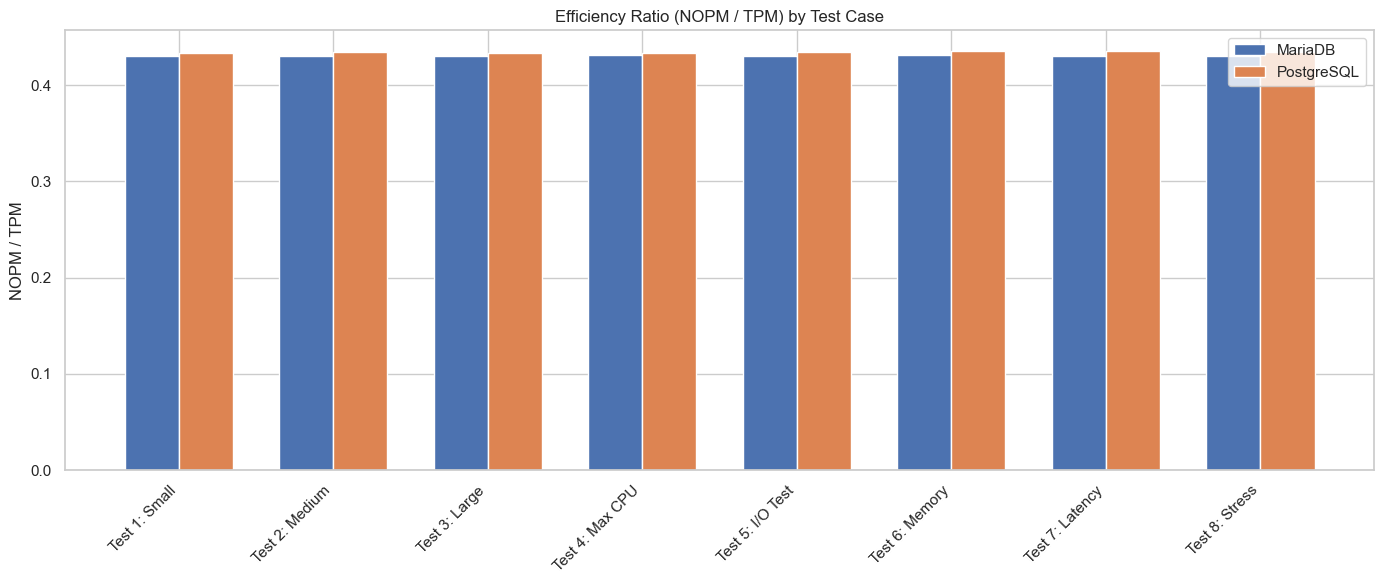

In [26]:
df_combined['efficiency'] = df_combined['final_nopm'] / df_combined['final_tpm']

efficiency_stats = df_combined.groupby(['test_id', 'test_name', 'db'])['efficiency'].mean().reset_index()

x_labels = [f"Test {tid}: {name}" for tid, name in efficiency_stats[['test_id', 'test_name']].drop_duplicates().values]
x = np.arange(len(x_labels))
width = 0.35

maria = efficiency_stats[efficiency_stats['db'] == 'MariaDB']['efficiency']
pg = efficiency_stats[efficiency_stats['db'] == 'PostgreSQL']['efficiency']

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, maria, width=width, label="MariaDB")
plt.bar(x + width/2, pg, width=width, label="PostgreSQL")
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("NOPM / TPM")
plt.title("Efficiency Ratio (NOPM / TPM) by Test Case")
plt.legend()
plt.tight_layout()
plt.show()

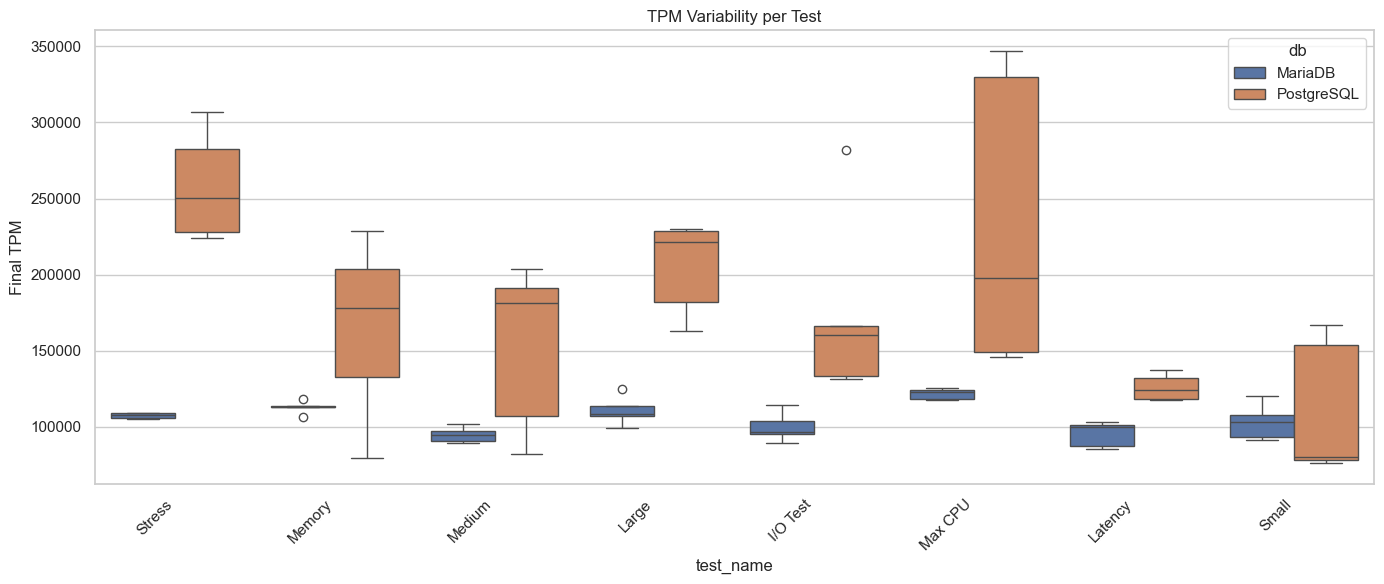

In [27]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_combined, x='test_name', y='final_tpm', hue='db')
plt.title("TPM Variability per Test")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Final TPM")
plt.tight_layout()
plt.show()

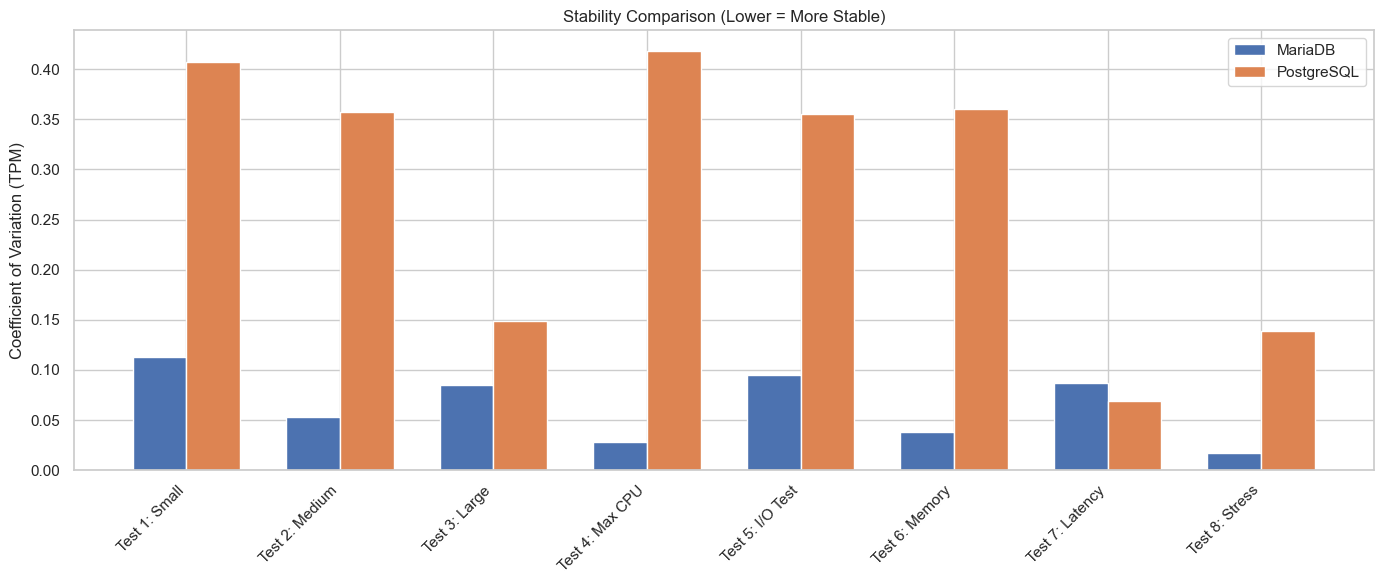

In [28]:
cv_stats = df_combined.groupby(['test_id', 'test_name', 'db']).agg(
    mean_tpm=('final_tpm', 'mean'),
    std_tpm=('final_tpm', 'std')
).reset_index()
cv_stats['cv_tpm'] = cv_stats['std_tpm'] / cv_stats['mean_tpm']
cv_pivot = cv_stats.pivot(index=['test_id', 'test_name'], columns='db', values='cv_tpm').reset_index()

x_labels = [f"Test {tid}: {name}" for tid, name in zip(cv_pivot['test_id'], cv_pivot['test_name'])]
x = np.arange(len(cv_pivot))
width = 0.35

maria = cv_pivot['MariaDB']
pg = cv_pivot['PostgreSQL']


plt.figure(figsize=(14, 6))
plt.bar(x - width/2, maria, width=width, label='MariaDB')
plt.bar(x + width/2, pg, width=width, label='PostgreSQL')
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Coefficient of Variation (TPM)")
plt.title("Stability Comparison (Lower = More Stable)")
plt.legend()
plt.tight_layout()
plt.show()




In [29]:
# ---- Load MariaDB summaries ----
df_mariadb_0 = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES0/summary.csv')
df_mariadb_0['warehouse'] = 0

df_mariadb_1 = pd.read_csv('hammer_scripts/Mariadb_logs_ALLWAREHOUSES1/summary.csv')
df_mariadb_1['warehouse'] = 1

df_mariadb = pd.concat([df_mariadb_0, df_mariadb_1], ignore_index=True)

mariadb_grouped = df_mariadb.groupby(['test_id', 'test_name', 'warehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    avg_nopm=('final_nopm', 'mean')
).reset_index()

best_mariadb = mariadb_grouped.loc[mariadb_grouped['avg_tpm'].idxmax()]
print("Best MariaDB Configuration:")
print(best_mariadb)

if best_mariadb['warehouse'] == 0:
    print("This MariaDB configuration is from warehouse 0.")
else:
    print("This MariaDB configuration is from warehouse 1.")

df_postgres_0 = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES0/summary.csv')
df_postgres_0['warehouse'] = 0

df_postgres_1 = pd.read_csv('hammer_scripts/Postgres_logs_ALLWAREHOUSES1/summary.csv')
df_postgres_1['warehouse'] = 1

df_postgres = pd.concat([df_postgres_0, df_postgres_1], ignore_index=True)

postgres_grouped = df_postgres.groupby(['test_id', 'test_name', 'warehouse']).agg(
    avg_tpm=('final_tpm', 'mean'),
    avg_nopm=('final_nopm', 'mean')
).reset_index()

best_postgres = postgres_grouped.loc[postgres_grouped['avg_tpm'].idxmax()]
print("Best PostgreSQL Configuration:")
print(best_postgres)

if best_postgres['warehouse'] == 0:
    print("This PostgreSQL configuration is from warehouse 0.")
else:
    print("This PostgreSQL configuration is from warehouse 1.")


Best MariaDB Configuration:
test_id             4
test_name     Max CPU
warehouse           0
avg_tpm      121708.2
avg_nopm      52446.6
Name: 6, dtype: object
This MariaDB configuration is from warehouse 0.
Best PostgreSQL Configuration:
test_id             8
test_name      Stress
warehouse           1
avg_tpm      275695.8
avg_nopm     119838.8
Name: 15, dtype: object
This PostgreSQL configuration is from warehouse 1.


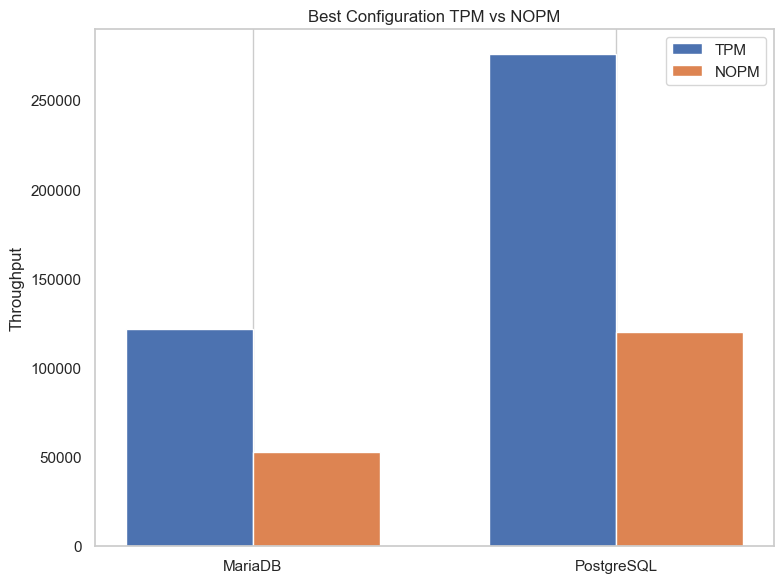

In [ ]:
best_configs = pd.concat([best_mariadb, best_postgres], axis=1)

labels = ['MariaDB', 'PostgreSQL']
avg_tpm = [best_mariadb['avg_tpm'], best_postgres['avg_tpm']]
avg_nopm = [best_mariadb['avg_nopm'], best_postgres['avg_nopm']]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, avg_tpm, width=width, label='TPM')
plt.bar([i + width for i in x], avg_nopm, width=width, label='NOPM')
plt.xticks([i + width / 2 for i in x], labels)
plt.ylabel("Throughput")
plt.title("Best Configuration TPM vs NOPM")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
extractor.extract_all_logs_to_csv("hammer_scripts/Mariadb_logs_best")

✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu100_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu50_wh100_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu50_wh20_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu50_wh20_mc500_bp4G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu50_wh30_mc500_bp2G_lb128_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu50_wh50_mc500_bp2G_lb64_dict.txt
✅ Cleaned: hammer_scripts/Mariadb_logs_best\tpcc_vu60_wh20_mc500_bp2G_lb64_dict.txt
Extracted 32 TPM from tpcc_vu100_wh20_mc500_bp2G_lb64_run1.log (Test 44: Max CPU4 - Best MariaDB)
Extracted 32 TPM from tpcc_vu100_wh20_mc500_bp2G_lb64_run2.log (Test 44: Max CPU4 - Best MariaDB)
Extracted 33 TPM from tpcc_vu100_wh20_mc500_bp2G_lb64_run3.log (Test 44: Max CPU4 - Best MariaDB)
Extracted 33 TPM from tpcc_vu100_wh20_mc500_bp2G_lb64_run4.log (Test 44: Max CPU4 - Best MariaDB)
Extracted 33 TPM 

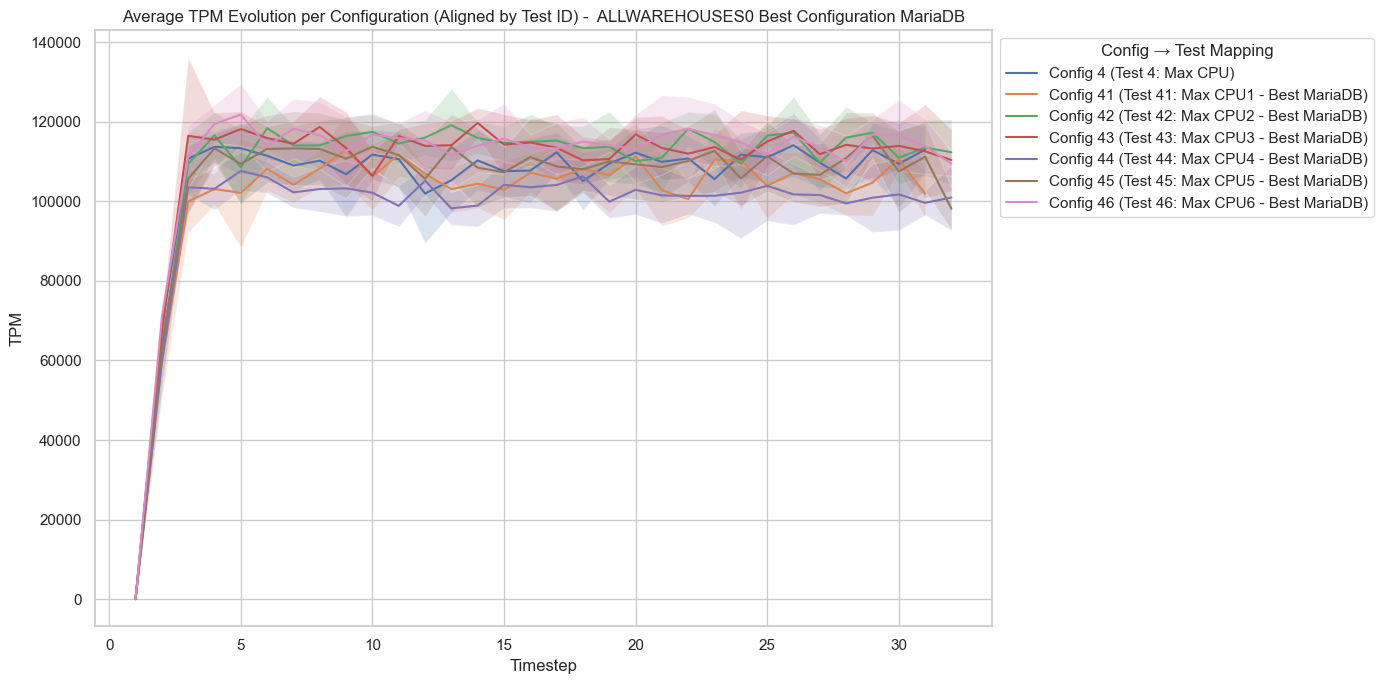

In [ ]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_best/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) -  ALLWAREHOUSES0 Best Configuration MariaDB")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

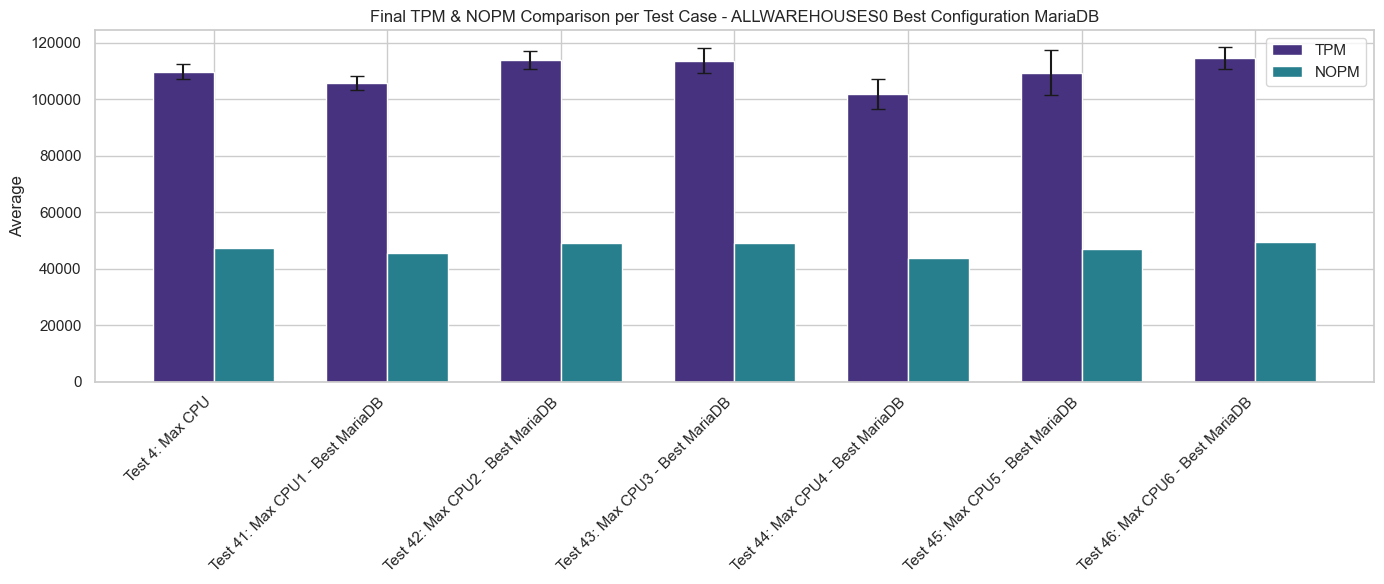

In [ ]:
df = pd.read_csv('hammer_scripts/Mariadb_logs_best/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]
df['test_id'] = df['test_id'].astype(int)
df['test_name'] = df['test_name'].astype(str)

summary_stats = df.groupby(['test_id', 'test_name']).agg(
    avg_final_tpm=('final_tpm', 'mean'),
    std_final_tpm=('final_tpm', 'std'),
    avg_final_nopm=('final_nopm', 'mean')
).reset_index()

summary_stats = summary_stats.sort_values('test_id')

x_labels = [f"Test {tid}: {name}" for tid, name in zip(summary_stats['test_id'], summary_stats['test_name'])]
x = np.arange(len(summary_stats)) 
width = 0.35 

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

plt.bar(
    x - width/2,
    summary_stats['avg_final_tpm'],
    width=width,
    label='TPM',
    yerr=summary_stats['std_final_tpm'],
    capsize=5,
    color=sns.color_palette('viridis')[0]
)

plt.bar(
    x + width/2,
    summary_stats['avg_final_nopm'],
    width=width,
    label='NOPM',
    color=sns.color_palette('viridis')[2]
)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel("Average")
plt.title("Final TPM & NOPM Comparison per Test Case - ALLWAREHOUSES0 Best Configuration MariaDB")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Best configuration by average TPM
best_tpm_row = summary_stats.loc[summary_stats['avg_final_tpm'].idxmax()]
print("Best TPM configuration in ALLWAREHOUSES0 Best Configuration:")
print(best_tpm_row)
# Top 3 configurations
top3 = summary_stats.sort_values('avg_final_tpm', ascending=False).head(3)
print("Top 3 Configurations by Avg TPM in ALLWAREHOUSES0 Best Configuration:")
print(top3)

Best TPM configuration in ALLWAREHOUSES0 Best Configuration:
test_id                                46
test_name         Max CPU6 - Best MariaDB
avg_final_tpm                    114596.2
std_final_tpm                 3908.292556
avg_final_nopm                    49343.6
Name: 6, dtype: object
Top 3 Configurations by Avg TPM in ALLWAREHOUSES0 Best Configuration:
   test_id                test_name  avg_final_tpm  std_final_tpm  \
6       46  Max CPU6 - Best MariaDB       114596.2    3908.292556   
2       42  Max CPU2 - Best MariaDB       113938.2    3033.883435   
3       43  Max CPU3 - Best MariaDB       113655.4    4482.362580   

   avg_final_nopm  
6         49343.6  
2         49060.8  
3         48974.2  


In [ ]:
extractor.extract_all_logs_to_csv("hammer_scripts/logs_postgres_Best")

✅ Cleaned: hammer_scripts/logs_postgres_Best\pg_vu100_wh100_mc1000_sb4GB_wb128_dict.txt
✅ Cleaned: hammer_scripts/logs_postgres_Best\pg_vu100_wh150_mc1000_sb4GB_wb128_dict.txt
✅ Cleaned: hammer_scripts/logs_postgres_Best\pg_vu100_wh50_mc1000_sb4GB_wb128_dict.txt
✅ Cleaned: hammer_scripts/logs_postgres_Best\pg_vu100_wh50_mc1000_sb4GB_wb256_dict.txt
✅ Cleaned: hammer_scripts/logs_postgres_Best\pg_vu150_wh50_mc1000_sb4GB_wb128_dict.txt
Extracted 6 TPM from pg_vu100_wh100_mc1000_sb4GB_wb128_run1.log (Test 81: Stress1 - Best PostgreSQL)
Extracted 6 TPM from pg_vu100_wh100_mc1000_sb4GB_wb128_run2.log (Test 81: Stress1 - Best PostgreSQL)
Extracted 6 TPM from pg_vu100_wh100_mc1000_sb4GB_wb128_run3.log (Test 81: Stress1 - Best PostgreSQL)
Extracted 6 TPM from pg_vu100_wh100_mc1000_sb4GB_wb128_run4.log (Test 81: Stress1 - Best PostgreSQL)
Extracted 6 TPM from pg_vu100_wh100_mc1000_sb4GB_wb128_run5.log (Test 81: Stress1 - Best PostgreSQL)
Extracted 32 TPM from pg_vu100_wh150_mc1000_sb4GB_wb128_ru

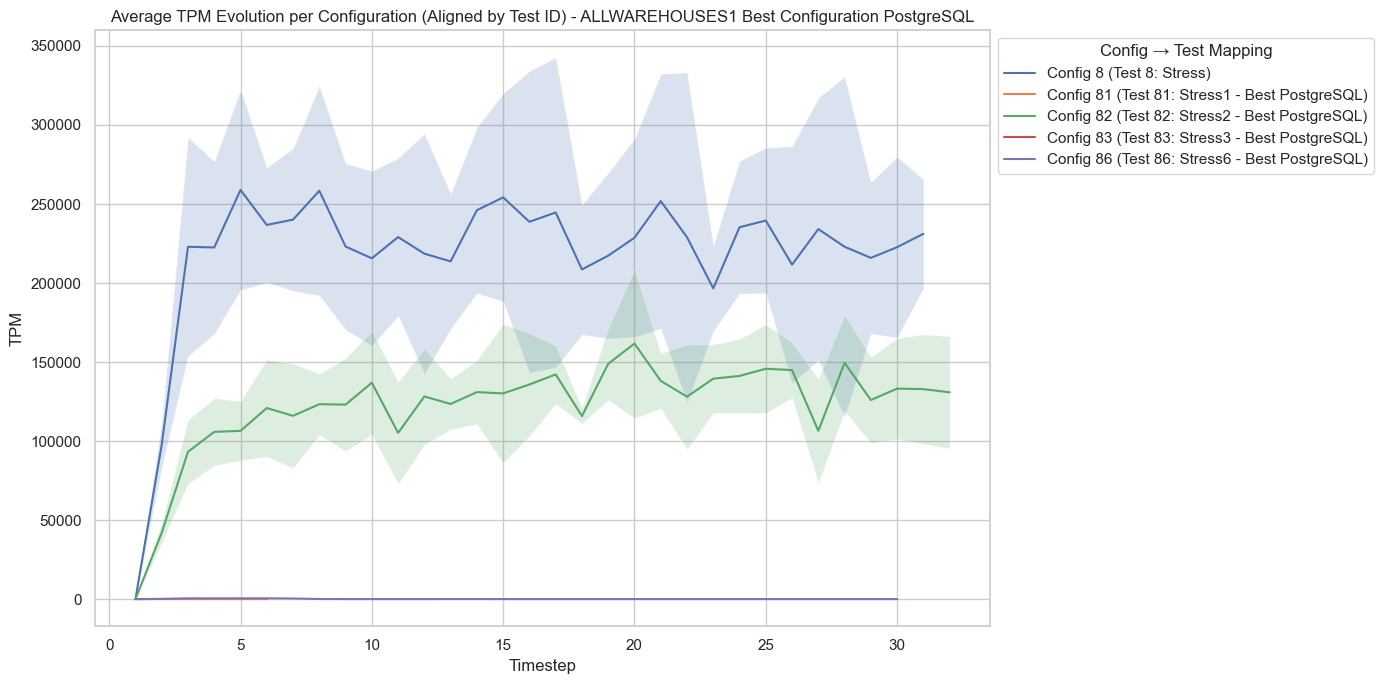

In [ ]:
df = pd.read_csv('hammer_scripts/logs_postgres_Best/summary.csv')
df['config_id'] = df['filename'].str.replace(r'_run\d+\.log$', '', regex=True)
df['tpm_values'] = df['tpm_values'].apply(ast.literal_eval)

df = df[df['test_id'].notna()]

df['test_id'] = df['test_id'].astype(int)
df['config_num'] = df['test_id'].astype(str)

grouped = df.groupby('test_id')

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for test_id, group in grouped:
    tpm_lists = group['tpm_values'].tolist()
    min_len = min(len(run) for run in tpm_lists)
    tpm_matrix = np.array([run[:min_len] for run in tpm_lists])

    mean_tpm = tpm_matrix.mean(axis=0)
    std_tpm = tpm_matrix.std(axis=0)
    x = np.arange(1, min_len + 1)

    first_row = group.iloc[0]
    config_label = str(test_id)
    test_label = f"Test {test_id}: {first_row['test_name']}"

    label = f"Config {config_label} ({test_label})"
    plt.plot(x, mean_tpm, label=label)
    plt.fill_between(x, mean_tpm - std_tpm, mean_tpm + std_tpm, alpha=0.2)

plt.title("Average TPM Evolution per Configuration (Aligned by Test ID) - ALLWAREHOUSES1 Best Configuration PostgreSQL")
plt.xlabel("Timestep")
plt.ylabel("TPM")
plt.legend(title="Config → Test Mapping", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()